In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("incl/")

import ELPH_utils
import codimar

from RedDimApprox import RedDimApprox

In [3]:
runs = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=80.npz')

# runs = runs[:100:1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 80


In [8]:
dim_reducer = codimar.dim_compressor.SVD()
# dim_reducer = codimar.dim_compressor.FFT(sorted=True)
# dim_reducer = codimar.dim_compressor.Hermite(sample_max = 1.856, sorted=True, optimize=True, orthogonalize=False, train_rdim=20)

model = RedDimApprox(runs, dim_reducer)
model.train()
# print(dim_reducer.sample_max)

print(model.get_error(runs[9], rdim=20, norm='std'))

0.00038442929012784014


In [14]:
dim_reducer = codimar.dim_compressor.SVD()
# dim_reducer = codimar.dim_compressor.FFT(sorted=True)
# dim_reducer = codimar.dim_compressor.Hermite(sample_max = 1.856, sorted=True, optimize=True, orthogonalize=True, train_rdim=40)

model = RedDimApprox(dim_reducer=dim_reducer)

train_kwargs = {'rdim':10}

scores = ELPH_utils.get_KFold_CV_scores(model, runs, folds=10, seed=817, norms=['std','max'], train_kwargs=train_kwargs)

print('std error: ', str(np.mean(scores[0])) + '+-' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + '+-' + str(np.std(scores[1])) )


std error:  0.004943199493290012+-0.0034486950208930793
max error:  0.10565892356228863+-0.10562436500204257


In [ ]:
norm = 'max'
threshold = 0.01

# n_kmax_ar = [220,230]
n_kmax_ar = [10,20,30,40]
# n_kmax_ar = np.arange(10,235,10)
n_kmax_ar = np.arange(50,255,10)

rdim_buffer = 5
previous_min_rdim = 1 + rdim_buffer
min_rdim_ar = []

for k, n_kmax in enumerate(n_kmax_ar):
    runs = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax='+str(n_kmax)+'.npz')
    n_runs = len(runs)
    assert n_kmax == runs[0].shape[0]
    
    print(n_runs, 'loaded with n_kmax =', n_kmax)
    
    for rdim in range(previous_min_rdim-rdim_buffer,n_kmax+1):
        
        try:
#             dim_reducer = codimar.dim_compressor.SVD()
#             dim_reducer = codimar.dim_compressor.FFT(sorted=True)
            dim_reducer = codimar.dim_compressor.Hermite(sorted=True, optimize=True, orthogonalize=True, train_rdim=rdim)

            model = RedDimApprox(dim_reducer=dim_reducer)

            train_kwargs = {'rdim':rdim}

            scores = ELPH_utils.get_KFold_CV_scores(model, runs, folds=10, seed=817, norms=[norm], train_kwargs=train_kwargs)
            
            mean = np.mean(scores[0])
            std = np.std(scores[0])

            score = mean+std

            if score < threshold:
                previous_min_rdim = rdim
                min_rdim_ar.append(rdim)
                print('min rdim:', rdim, 'mean + std', score)
                break
        except:
            score = 10.0
            
    if score > threshold:        
        min_rdim_ar.append(rdim)
        print('max rdim reached:', rdim, 'mean score', score)
    

1000 loaded with n_kmax = 50
min rdim: 50 mean + std 1.6912937099698176e-15
1000 loaded with n_kmax = 60
min rdim: 60 mean + std 1.9181227970694125e-15
1000 loaded with n_kmax = 70
min rdim: 70 mean + std 1.9893231541981966e-15
1000 loaded with n_kmax = 80


(21, 2)
[[ 50  50]
 [ 60  56]
 [ 70  64]
 [ 80  73]
 [ 90  82]
 [100  91]
 [110 101]
 [120 113]
 [130 124]
 [140 137]
 [150 149]
 [160 158]
 [170 167]
 [180 173]
 [190 178]
 [200 181]
 [210 190]
 [220 199]
 [230 208]
 [240 217]
 [250 226]]


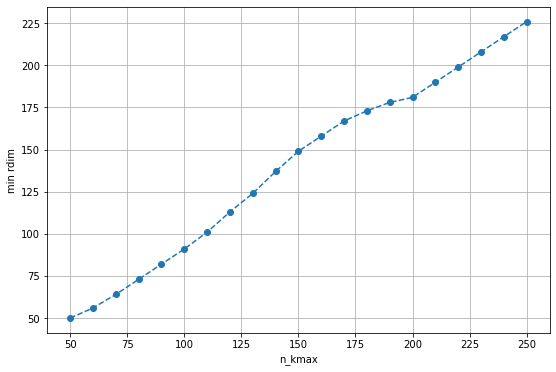

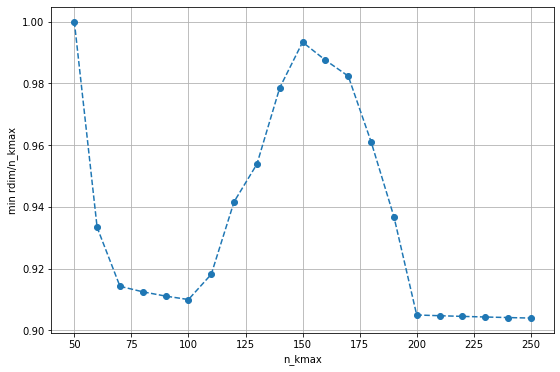

In [8]:
n_kmax_ar = np.asarray(n_kmax_ar)
min_rdim_ar = np.asarray(min_rdim_ar)

data = np.stack((n_kmax_ar[:min_rdim_ar.size],min_rdim_ar),axis=1)

# prev_data = np.loadtxt('/home/agluedge/Preprints/ELPH/figs/red_dim_apprx/hermite_max')
# data = np.concatenate((prev_data,data),axis=0)


print(data.shape)
print(data)

# np.savetxt('/home/agluedge/Preprints/ELPH/figs/red_dim_apprx/FFT_max_2', data)



plt.grid()
plt.plot(data[:,0],data[:,1], '--', marker='o')
plt.xlabel('n_kmax')
plt.ylabel('min rdim')
plt.show()


plt.grid()
plt.plot(data[:,0],data[:,1]/data[:,0], '--', marker='o')
plt.xlabel('n_kmax')
plt.ylabel('min rdim/n_kmax')
plt.show()